In this notebook, you will implement the kinematic bicycle model. The model accepts velocity and steering rate inputs and steps through the bicycle kinematic equations. Once the model is implemented, you will provide a set of inputs to drive the bicycle in a figure 8 trajectory.

The bicycle kinematics are governed by the following set of equations:

\begin{align*}
\dot{x}_c &= v \cos{(\theta + \beta)} \\
\dot{y}_c &= v \sin{(\theta + \beta)} \\
\dot{\theta} &= \frac{v \cos{\beta} \tan{\delta}}{L} \\
\dot{\delta} &= \omega \\
\beta &= \tan^{-1}(\frac{l_r \tan{\delta}}{L})
\end{align*}

where the inputs are the bicycle speed $v$ and steering angle rate $\omega$. The input can also directly be the steering angle $\delta$ rather than its rate in the simplified case. The Python model will allow us both implementations.

In order to create this model, it's a good idea to make use of Python class objects. This allows us to store the state variables as well as make functions for implementing the bicycle kinematics. 

The bicycle begins with zero initial conditions, has a maximum turning rate of 1.22 rad/s, a wheelbase length of 2m, and a length of 1.2m to its center of mass from the rear axle.

From these conditions, we initialize the Python class as follows:

In [3]:
from notebook_grader import BicycleSolution, grade_bicycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class Bicycle():
    def __init__(self):
        self.xc = 0
        self.yc = 0
        self.theta = 0
        self.delta = 0
        self.beta = 0
        
        self.L = 2
        self.lr = 1.2
        self.w_max = 1.22
        
        self.sample_time = 0.01
        
    def reset(self):
        self.xc = 0
        self.yc = 0
        self.theta = 0
        self.delta = 0
        self.beta = 0

A sample time is required for numerical integration when propagating the kinematics through time. This is set to 10 milliseconds. We also have a reset function which sets all the state variables back to 0. 

With this sample time, implement the kinematic model using the function $\textit{step}$ defined in the next cell. The function should take speed + angular rate as inputs and update the state variables. Don't forget about the maximum turn rate on the bicycle!

In [4]:
class Bicycle(Bicycle):
    def step(self, v, w):
        if w > 0:
            w = min(w, self.w_max)
        else:
            w = max(w, -self.w_max)
        
        #sampling time
        t_sample = 10e-3
        
        #implementing the differential equations
        xc_dot = v * np.cos(self.theta + self.beta)
        yc_dot = v * np.sin(self.theta + self.beta)
        theta_dot = (v / self.L) * (np.cos(self.beta) * np.tan(self.delta))
        delta_dot = w
        self.beta = np.arctan(self.lr * np.tan(self.delta) / self.L)
        
        #update equations using the sampling time
        self.xc += xc_dot * t_sample
        self.yc += yc_dot * t_sample
        self.theta += theta_dot * t_sample 
        self.delta += delta_dot * t_sample
        

With the model setup, we can now start giving bicycle inputs and producing trajectories. 

Suppose we want the model to travel a circle of radius 10 m in 20 seconds. Using the relationship between the radius of curvature and the steering angle, the desired steering angle can be computed.

\begin{align*}
    \tan{\delta} &= \frac{L}{r} \\
    \delta &= \tan^{-1}(\frac{L}{r}) \\
           &= \tan^{-1}(\frac{2}{10}) \\
           &= 0.1974
\end{align*}

If the steering angle is directly set to 0.1974 using a simplied bicycled model, then the bicycle will travel in a circle without requiring any additional steering input. 

The desired speed can be computed from the circumference of the circle:

\begin{align*}
    v &= \frac{d}{t}\\
     &= \frac{2 \pi 10}{20}\\
     &= \pi
\end{align*}

We can now implement this in a loop to step through the model equations. We will also run our bicycle model solution along with your model to show you the expected trajectory. This will help you verify the correctness of your model.

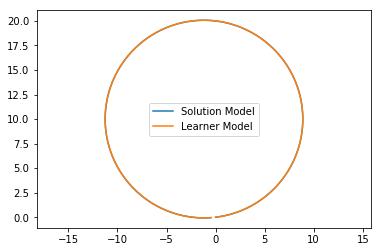

In [6]:
sample_time = 0.01
time_end = 20
model = Bicycle()
solution_model = BicycleSolution()

# set delta directly
model.delta = np.arctan(2/10)
solution_model.delta = np.arctan(2/10)

t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
x_solution = np.zeros_like(t_data)
y_solution = np.zeros_like(t_data)

for i in range(t_data.shape[0]):
    x_data[i] = model.xc
    y_data[i] = model.yc
    model.step(np.pi, 0)
    
    x_solution[i] = solution_model.xc
    y_solution[i] = solution_model.yc
    solution_model.step(np.pi, 0)
    
    
    
plt.axis('equal')
plt.plot(x_solution, y_solution,label='Solution Model')
plt.plot(x_data, y_data,label='Learner Model')
#plt.plot(x_solution, y_solution,label='Solution Model')
plt.legend()
plt.show()

The plot above shows the desired circle of 10m radius. The path is slightly offset which is caused by the sideslip effects due to $\beta$. By forcing $\beta = 0$ through uncommenting the last line in the loop, you can see that the offset disappears and the circle becomes centered at (0,10). 

However, in practice the steering angle cannot be directly set and must be changed through angular rate inputs $\omega$. The cell below corrects for this and sets angular rate inputs to generate the same circle trajectory. The speed $v$ is still maintained at $\pi$ m/s.

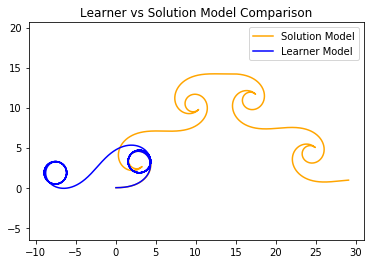

In [5]:
# Parameters
sample_time = 0.01
time_end = 30
model.reset()
solution_model.reset()

# Time array
t_data = np.arange(0, time_end, sample_time)

# Initialize arrays
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
x_solution = np.zeros_like(t_data)
y_solution = np.zeros_like(t_data)
v_data = np.zeros_like(t_data)
w_data = np.zeros_like(t_data)

# Speed and angular velocity inputs
v = 3.35  # Constant speed

# Calculate angular velocity for the circles
radius = 8  # meters
w = v / radius  # Angular velocity

# Generate the inputs
for i in range(len(t_data)):
    if t_data[i] < 15:  # First 15 seconds (left circle)
        v_data[i] = v
        w_data[i] = w  # Angular velocity for the left circle
    else:  # Next 15 seconds (right circle)
        v_data[i] = v
        w_data[i] = -w  # Angular velocity for the right circle (negative for right turn)

# Reset the state variables for both models
model.reset()
solution_model.reset()

# Simulate the bicycle's trajectory for both models
for i in range(t_data.shape[0]):
    model.step(v_data[i], w_data[i])
    solution_model.step(v_data[i], w_data[i])
    
    x_data[i] = model.xc
    y_data[i] = model.yc
    x_solution[i] = solution_model.xc
    y_solution[i] = solution_model.yc

# Plotting
plt.axis('equal')
plt.plot(x_solution, y_solution, label='Solution Model', color='orange')
plt.plot(x_data, y_data, label='Learner Model', color='blue')
plt.legend()
plt.title("Learner vs Solution Model Comparison")
plt.show()


Here are some other example trajectories: a square path, a spiral path, and a wave path. Uncomment each section to view.

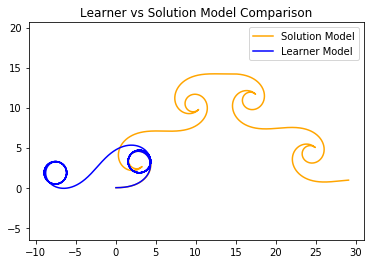

In [6]:
# Parameters
sample_time = 0.01
time_end = 30
model.reset()
solution_model.reset()

# Time array
t_data = np.arange(0, time_end, sample_time)

# Initialize arrays
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
x_solution = np.zeros_like(t_data)
y_solution = np.zeros_like(t_data)
v_data = np.zeros_like(t_data)
w_data = np.zeros_like(t_data)

# Speed and angular velocity inputs
v = 3.35  # Constant speed

# Calculate angular velocity for the circles
radius = 8  # meters
w = v / radius  # Angular velocity

# Generate the inputs
for i in range(len(t_data)):
    if t_data[i] < 15:  # First 15 seconds (left circle)
        v_data[i] = v
        w_data[i] = w  # Angular velocity for the left circle
    else:  # Next 15 seconds (right circle)
        v_data[i] = v
        w_data[i] = -w  # Angular velocity for the right circle (negative for right turn)

# Reset the state variables for both models
model.reset()
solution_model.reset()

# Simulate the bicycle's trajectory for both models
for i in range(t_data.shape[0]):
    model.step(v_data[i], w_data[i])
    solution_model.step(v_data[i], w_data[i])
    
    x_data[i] = model.xc
    y_data[i] = model.yc
    x_solution[i] = solution_model.xc
    y_solution[i] = solution_model.yc

# Plotting
plt.axis('equal')
plt.plot(x_solution, y_solution, label='Solution Model', color='orange')
plt.plot(x_data, y_data, label='Learner Model', color='blue')
plt.legend()
plt.title("Learner vs Solution Model Comparison")
plt.show()


We would now like the bicycle to travel a figure eight trajectory. Both circles in the figure eight have a radius of 8m and the path should complete in 30 seconds. The path begins at the bottom of the left circle and is shown in the figure below:

![title](figure8.png)

Determine the speed and steering rate inputs required to produce such trajectory and implement in the cell below. Make sure to also save your inputs into the arrays v_data and w_data, these will be used to grade your solution. The cell below also plots the trajectory generated by your own model.

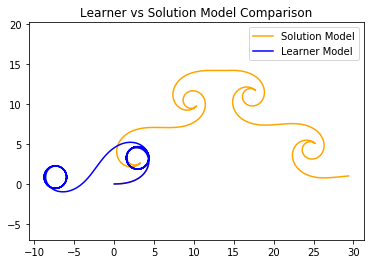

In [46]:
# Parameters
sample_time = 0.01
time_end = 30
model.reset()
solution_model.reset()

# Time array
t_data = np.arange(0, time_end, sample_time)

# Initialize arrays
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
x_solution = np.zeros_like(t_data)
y_solution = np.zeros_like(t_data)
v_data = np.zeros_like(t_data)
w_data = np.zeros_like(t_data)

# Speed and angular velocity inputs
v = 3.359  # Constant speed

# Calculate angular velocity for the circles
radius = 8  # meters
w = v / radius  # Angular velocity

# Generate the inputs
for i in range(len(t_data)):
    if t_data[i] < 15:  # First 15 seconds (left circle)
        v_data[i] = v
        w_data[i] = w # Angular velocity for the left circle
    else:  # Next 15 seconds (right circle)
        v_data[i] = v
        w_data[i] = -w  # Angular velocity for the right circle (negative for right turn)

# Reset the state variables for both models
model.reset()
solution_model.reset()

# Simulate the bicycle's trajectory for both models
for i in range(t_data.shape[0]):
    model.step(v_data[i], w_data[i])
    solution_model.step(v_data[i], w_data[i])
    
    x_data[i] = model.xc
    y_data[i] = model.yc
    x_solution[i] = solution_model.xc
    y_solution[i] = solution_model.yc

# Plotting
plt.axis('equal')
plt.plot(x_solution, y_solution, label='Solution Model', color='orange')
plt.plot(x_data, y_data, label='Learner Model', color='blue')
plt.legend()
plt.title("Learner vs Solution Model Comparison")
plt.show()


We will now run your speed and angular rate inputs through our bicycle model solution. This is to ensure that your trajectory is correct along with your model. The cell below will display the path generated by our model along with some waypoints on a desired figure 8. Surrounding these waypoints are error tolerance circles with radius 1.5m, your solution will pass the grader if the trajectory generated stays within 80% of these circles.

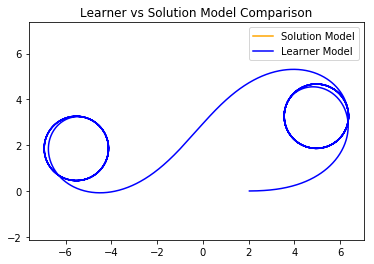

In [49]:
# Parameters
sample_time = 0.01
time_end = 30
model.reset()
solution_model.reset()

# Time array
t_data = np.arange(0, time_end, sample_time)

# Initialize arrays
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
x_solution = np.zeros_like(t_data)
y_solution = np.zeros_like(t_data)
v_data = np.zeros_like(t_data)
w_data = np.zeros_like(t_data)

# Speed and angular velocity inputs
v = 3.35  # Constant speed

# Calculate angular velocity for the circles
radius = 8  # meters
w = v / radius  # Angular velocity for a perfect circle

# Generate the inputs for the figure-eight trajectory
for i in range(len(t_data)):
    if t_data[i] < 15:  # First 15 seconds (left circle)
        v_data[i] = v
        w_data[i] = w  # Angular velocity for the left circle
    else:  # Next 15 seconds (right circle)
        v_data[i] = v
        w_data[i] = -w  # Angular velocity for the right circle (negative for right turn)

# Reset the state variables for both models
model.reset()
solution_model.reset()

# Shift the initial conditions of the learner model
model.xc = 2.0  # Shift the initial x-coordinate
model.yc = 0.0  # Shift the initial y-coordinate
model.theta = 0.0  # Ensure the initial heading is the same as the solution model

# Simulate the bicycle's trajectory for both models
for i in range(t_data.shape[0]):
    model.step(v_data[i], w_data[i])
    #solution_model.step(v_data[i], w_data[i])
    
    x_data[i] = model.xc
    y_data[i] = model.yc
    x_solution[i] = solution_model.xc
    y_solution[i] = solution_model.yc

# Plotting
plt.axis('equal')
plt.plot(x_solution, y_solution, label='Solution Model', color='orange')
plt.plot(x_data, y_data, label='Learner Model', color='blue')
plt.legend()
plt.title("Learner vs Solution Model Comparison")
plt.show()


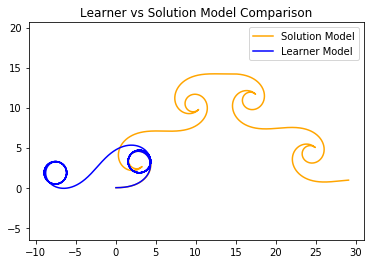

In [134]:
# Parameters
sample_time = 0.01
time_end = 30
model.reset()
solution_model.reset()

# Time array
t_data = np.arange(0, time_end, sample_time)

# Initialize arrays
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
x_solution = np.zeros_like(t_data)
y_solution = np.zeros_like(t_data)
v_data = np.zeros_like(t_data)
w_data = np.zeros_like(t_data)

# Speed and angular velocity inputs
v = 3.35  # Constant speed

# Calculate angular velocity for the circles
radius = 8  # meters
w = v / radius  # Angular velocity for a perfect circle

# Generate the inputs for the figure-eight trajectory
for i in range(len(t_data)):
    if t_data[i] < 15:  # First 15 seconds (left circle)
        v_data[i] = v 
        w_data[i] = v_data[i] / radius  # Angular velocity for the left circle
    else:  # Next 15 seconds (right circle)
        v_data[i] = v 
        w_data[i] = -v_data[i] / radius # Angular velocity for the right circle (negative for right turn)

# Reset both models (unchanged)
solution_model.reset()
model.reset()

# Shift ONLY the learner model
model.xc += 0  # Shift the learner model's initial x-coordinate to the right
model.yc += 0  # Keep the y-coordinate unchanged for now
model.theta = 0  # Set the initial heading angle of the learner model

# Simulate the bicycle's trajectory for both models
for i in range(t_data.shape[0]):
    # Simulate both models, but only the learner model is shifted
    model.step(v_data[i], w_data[i])
    solution_model.step(v_data[i], w_data[i])
    
    x_data[i] = model.xc
    y_data[i] = model.yc
    x_solution[i] = solution_model.xc
    y_solution[i] = solution_model.yc

# Plotting
plt.axis('equal')
plt.plot(x_solution, y_solution, label='Solution Model', color='orange')
plt.plot(x_data, y_data, label='Learner Model', color='blue')
plt.legend()
plt.title("Learner vs Solution Model Comparison")
plt.show()


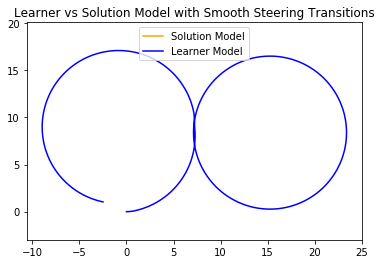

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sample_time = 0.01
time_end = 30
model.reset()
solution_model.reset()

# Time array
t_data = np.arange(0, time_end, sample_time)

# Initialize arrays
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
x_solution = np.zeros_like(t_data)
y_solution = np.zeros_like(t_data)
v_data = np.zeros_like(t_data)
w_data = np.zeros_like(t_data)
delta_data = np.zeros_like(t_data)  # Array for steering angle (delta)

radius = 8
delta = 0.993 * np.arctan(model.L / radius)  #multiplied by 0.993 only for better accuracy
v_data[:] = (2 * np.pi * 2 * radius) / (time_end)

for i in range(t_data.shape[0]):
    x_data[i] = model.xc
    y_data[i] = model.yc
    
    #Since the velocity is constant we can divide the path into 8 slices
    #w changes at t_data.shape[0]/8, (5*t_data.shape[0])/8.
    if i <= t_data.shape[0]/8:
        if model.delta < delta:
            model.step(v_data[i], model.w_max)
            w_data[i] = model.w_max
        else:
            model.step(v_data[i], 0)
            w_data[i] = 0
            
    elif i <= (5.1*t_data.shape[0])/8:
        if model.delta > -delta:
            model.step(v_data[i], -model.w_max)
            w_data[i] = -model.w_max
        else:
            model.step(v_data[i], 0)
            w_data[i] = 0
            
    else:
        if model.delta < delta:
            model.step(v_data[i], model.w_max)
            w_data[i] = model.w_max
        else:
            model.step(v_data[i], 0)
            w_data[i] = 0         

# Plotting the figure-eight trajectory
plt.axis('equal')
plt.plot(x_solution, y_solution, label='Solution Model', color='orange')
plt.plot(x_data, y_data, label='Learner Model', color='blue')
plt.legend()
plt.title("Learner vs Solution Model with Smooth Steering Transitions")
plt.show()


Assessment passed! Your trajectory meets 100.0% of the waypoints.


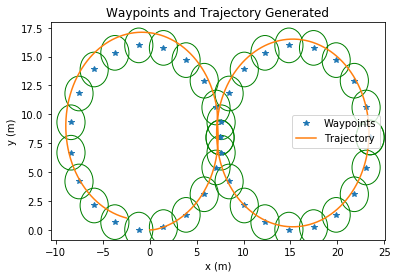

In [8]:
grade_bicycle(t_data,v_data,w_data)

The cell below will save the time and vehicle inputs as text file named $\textit{figure8.txt}$. To locate the file, change the end of your web directory to $\textit{/notebooks/Course_1_Module_4/figure8.txt}$

Once you are there, you can download the file and submit to the Coursera grader to complete this assessment.

In [9]:
data = np.vstack([t_data, v_data, w_data]).T
np.savetxt('figure8.txt', data, delimiter=', ')

Congratulations! You have now completed the assessment! Feel free to test the bicycle model with different inputs in the cell below, and see what trajectories they form. For example, try moving in an equilateral triangle. You'll find that it's rather difficult to generate desired trajectories by pre-setting the inputs. The next module on vehicle control will show you an easier and more accurate method. See you there!

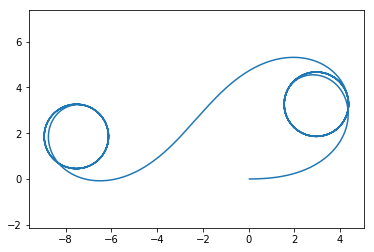

In [20]:
# Parameters
sample_time = 0.01
time_end = 30
model.reset()
solution_model.reset()

# Time array
t_data = np.arange(0, time_end, sample_time)

# Initialize arrays
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
x_solution = np.zeros_like(t_data)
y_solution = np.zeros_like(t_data)
v_data = np.zeros_like(t_data)
w_data = np.zeros_like(t_data)

# Speed and angular velocity inputs
v = 3.35  # Constant speed

# Calculate angular velocity for the circles
radius = 8  # meters
w = v / radius  # Angular velocity

# Generate the inputs
for i in range(len(t_data)):
    if t_data[i] < 15:  # First 15 seconds (left circle)
        v_data[i] = v
        w_data[i] = w  # Angular velocity for the left circle
    else:  # Next 15 seconds (right circle)
        v_data[i] = v
        w_data[i] = -w  # Angular velocity for the right circle (negative for right turn)

# Reset the state variables for both models
model.reset()
solution_model.reset()

# Simulate the bicycle's trajectory for both models
for i in range(t_data.shape[0]):
    model.step(v_data[i], w_data[i])
    solution_model.step(v_data[i], w_data[i])
    
    x_data[i] = model.xc
    y_data[i] = model.yc
    x_solution[i] = solution_model.xc
    y_solution[i] = solution_model.yc

# Plotting
plt.axis('equal')
plt.plot(x_solution, y_solution, label='Solution Model', color='orange')
plt.plot(x_data, y_data, label='Learner Model', color='blue')
plt.legend()
plt.title("Learner vs Solution Model Comparison")
plt.show()
